# QBS 108 Assignment 4
### LSTM for Text Classification

In [218]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
STOPWORDS = set(stopwords.words('english'))

2.2.0


In [219]:
import os
os.getcwd()

'/content/gdrive/My Drive/QBS108_hw4'

In [220]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
os.chdir('/content/gdrive/My Drive/QBS108_hw4/')

In [222]:
!ls

 Claire_Wang_model.pt	     hw4_train_reddit.csv   Untitled0.ipynb
 cnn.ipynb		     LSTM.ipynb		    wang_claire_qbs108_hw4.csv
 glove.6B.100d.txt	     Part1_images
 homework4_test_reddit.csv  'Part 2 Data'


In [260]:
reddit_train = pd.read_csv('hw4_train_reddit.csv', sep='\t')
reddit_test = pd.read_csv('homework4_test_reddit.csv', sep = '\t')
reddit_train.head()

,text,sub
0,Prevalence of Non-Java JVM Languages on JVM,java
1,Datetick &amp; pcolor,matlab
2,"[MySQL] Help with reading, writing, and then r...",SQL
3,Eclipse Jubula: Automated Functional Testing Tool,java
4,i really need a tutor but i have no time... pe...,java


In [261]:
# start with exploring the reddit data
reddit_train.describe()

,text,sub
count,13130,13130
unique,13033,7
top,Intro to IPC | Interprocess Communication,java
freq,3,1925


In [225]:
# group by subject and check how balanced the dataset is in terms of each sub
reddit_train.groupby('sub').describe()

text  ...     
              count  ... freq
sub                  ...     
C_Programming  1887  ...    3
Python         1839  ...    3
Rlanguage      1896  ...    2
SQL            1842  ...    2
java           1925  ...    2
javascript     1847  ...    3
matlab         1894  ...    3

[7 rows x 4 columns]

In [226]:
# check how long each text line are 
reddit_train['length'] = reddit_train['text'].apply(len)
reddit_train.head()

,text,sub,length
0,Prevalence of Non-Java JVM Languages on JVM,java,43
1,Datetick &amp; pcolor,matlab,21
2,"[MySQL] Help with reading, writing, and then r...",SQL,59
3,Eclipse Jubula: Automated Functional Testing Tool,java,49
4,i really need a tutor but i have no time... pe...,java,67


In [227]:
reddit_train['length'].describe()

count    13130.000000
mean        51.244402
std         28.613369
min          2.000000
25%         32.000000
50%         45.000000
75%         63.000000
max        299.000000
Name: length, dtype: float64

#### Text preprocessing: 
convert the input text into a sequence of numbers where each number represents a particular word. Start with remove the punctuations and stopwords.

In [0]:
reddit_train = reddit_train.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

reddit_train['text'] = reddit_train['text'].apply(clean_text)
reddit_train['text'] = reddit_train['text'].str.replace('\d+', '')

reddit_test['text'] = reddit_test['text'].apply(clean_text)
reddit_test['text'] = reddit_test['text'].str.replace('\d+', '')

In [229]:
reddit_test.head()

,text
0,issue concatenating field names
1,good idea mi right left outer joins
2,softrealtime python ms events
3,havent completely switched coffeescript issue ...
4,ms msql nvidia eists return else intel


Vectorize the text: convert each line of text into a vector with integers. Set the maximum word numbers to 11000 and set the maximum length per line to 300 (we see that the max length is actually 299 as shown above).

In [239]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 12000
# Max number of words in each text.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 150
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(reddit_train['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11309 unique tokens.


Pad the input data so that they are all in the same length for modeling:

In [240]:
X_train = tokenizer.texts_to_sequences(reddit_train['text'].values)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH) # padding
X_test = tokenizer.texts_to_sequences(reddit_test['text'].values)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train data tensor:', X_train.shape)
print('Shape of test data tensor:', X_test.shape)

Shape of train data tensor: (13130, 200)
Shape of test data tensor: (4377, 200)


Generate outcome/labels for train dataset:

In [241]:
# Converting categorical sub to integers
Y_train = pd.get_dummies(reddit_train['sub']).values
print('Shape of label tensor:', Y_train.shape)

Shape of label tensor: (13130, 7)


Test if tensorflow is running on GPU:

In [242]:
tf.test.gpu_device_name()

'/device:GPU:0'

Now is the time to build the whole architecture of the model.

My first layer in the model is an embedded layer with input dimensions = the number of each line of text, and output dimensions = embedding_dim = 150, which means it uses 150 length vectors to represent each word as the output. 

Second layer is LSTM layer with 150 memory units, which means that the dimensions of the hidden state and output state are both 150.

The output layer (the dense layer) create 7 output values, one for each sub from the reddit dataset. 

In [247]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM)))
model.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model.add(Dense(7, activation='softmax')) # number of classes is 7
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epoches = 5
batch_size = 128

# we can directly split the whole reddit_train data (include X_train and Y_train) to train and validation datset (with ratio=0.2)
lstm_model = model.fit(X_train, Y_train, epochs=epoches, batch_size=batch_size, validation_split =0.2, verbose=2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001))


Epoch 1/5
83/83 - 7s - loss: 1.5800 - accuracy: 0.4329 - val_loss: 1.0557 - val_accuracy: 0.6493
Epoch 2/5
83/83 - 6s - loss: 0.6321 - accuracy: 0.7941 - val_loss: 0.8470 - val_accuracy: 0.7148
Epoch 3/5
83/83 - 6s - loss: 0.3165 - accuracy: 0.9004 - val_loss: 0.9157 - val_accuracy: 0.7140
Epoch 4/5
83/83 - 6s - loss: 0.1915 - accuracy: 0.9419 - val_loss: 1.0683 - val_accuracy: 0.7174
Epoch 5/5
83/83 - 6s - loss: 0.1379 - accuracy: 0.9573 - val_loss: 1.1909 - val_accuracy: 0.7087


In [262]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 200, 150)          1800000   
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 300)               361200    
_________________________________________________________________
dense_56 (Dense)             (None, 150)               45150     
_________________________________________________________________
dense_57 (Dense)             (None, 7)                 1057      
Total params: 2,207,407
Trainable params: 2,207,407
Non-trainable params: 0
_________________________________________________________________


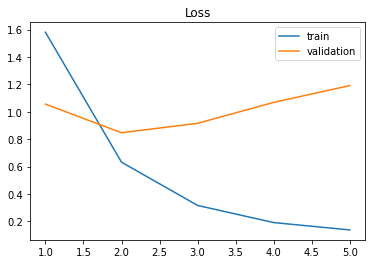

In [248]:
plt.title('Loss')
plt.plot([1,2,3,4,5],lstm_model.history['loss'], label='train')
plt.plot([1,2,3,4,5],lstm_model.history['val_loss'], label='validation')
plt.legend()
plt.show();

From the above result, we can see that when epoch reaches 2, the loss score is low enough. We may use epoch 3 for our optimal model below:

In [253]:
lstm_model = model.fit(X_train, Y_train, epochs=3, batch_size=batch_size, validation_split =0.1, verbose=2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.00001))

Epoch 1/3
93/93 - 6s - loss: 0.2204 - accuracy: 0.9477 - val_loss: 1.1392 - val_accuracy: 0.7144
Epoch 2/3
93/93 - 6s - loss: 0.0920 - accuracy: 0.9733 - val_loss: 1.4379 - val_accuracy: 0.7121
Epoch 3/3
93/93 - 6s - loss: 0.0607 - accuracy: 0.9809 - val_loss: 1.5621 - val_accuracy: 0.7113


Use the optimal model to predict on the test dataset:

In [254]:
pred = model.predict(X_test, verbose=2)
labels = ['C_Programming', 'Python', 'Rlanguage', 'SQL', 'java', 'javascript', 'matlab']

137/137 - 2s


In [255]:
len(pred)

4377

In [0]:
labels = ['C_Programming', 'Python','Rlanguage','SQL','java','javascript','matlab']

y_pred=[]
for i in range(4377):
  y_pred.append(labels[np.argmax(pred[i])])


In [257]:
y_pred = pd.DataFrame(y_pred)
y_pred.head()

,0
0,matlab
1,SQL
2,Python
3,javascript
4,SQL


In [0]:
y_pred.to_csv('wang_claire_qbs108_hw4.csv',header='classification', index=False)